In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LinearRegression

In [3]:
import eli5

Let's start loading the dataset we collected with the web crawler

In [4]:
dataset = pd.read_csv('dataset_new.csv')
print(dataset.shape)
dataset.head()

(5587, 23)


,id,belongs_to_collection,budget,genres,homepage,imdb_id,original_language,original_title,overview,popularity,...,release_date,runtime,spoken_languages,status,tagline,title,Keywords,cast,crew,wb_info
0,1,"[{'id': 313576, 'name': 'Hot Tub Time Machine ...",14000000,"[{'id': 35, 'name': 'Comedy'}]",NaN,tt2637294,en,Hot Tub Time Machine 2,"When Lou, who has become the ""father of the In...",6.575393,...,2/20/15,93.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The Laws of Space and Time are About to be Vio...,Hot Tub Time Machine 2,"[{'id': 4379, 'name': 'time travel'}, {'id': 9...","[{'cast_id': 4, 'character': 'Lou', 'credit_id...","[{'credit_id': '59ac067c92514107af02c8c8', 'de...",5963324.0
1,2,"[{'id': 107674, 'name': 'The Princess Diaries ...",40000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,tt0368933,en,The Princess Diaries 2: Royal Engagement,Mia Thermopolis is now a college graduate and ...,8.248895,...,2008/6/4,113.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,It can take a lifetime to find true love; she'...,The Princess Diaries 2: Royal Engagement,"[{'id': 2505, 'name': 'coronation'}, {'id': 42...","[{'cast_id': 1, 'character': 'Mia Thermopolis'...","[{'credit_id': '52fe43fe9251416c7502563d', 'de...",22956453.0
2,3,NaN,3300000,"[{'id': 18, 'name': 'Drama'}]",http://sonyclassics.com/whiplash/,tt2582802,en,Whiplash,"Under the direction of a ruthless instructor, ...",64.299990,...,2010/10/14,105.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The road to greatness can take you to the edge.,Whiplash,"[{'id': 1416, 'name': 'jazz'}, {'id': 1523, 'n...","[{'cast_id': 5, 'character': 'Andrew Neimann',...","[{'credit_id': '54d5356ec3a3683ba0000039', 'de...",135388.0
3,7,NaN,14000000,"[{'id': 27, 'name': 'Horror'}, {'id': 53, 'nam...",http://www.thepossessionmovie.com/,tt0431021,en,The Possession,A young girl buys an antique box at a yard sal...,7.286477,...,8/30/12,92.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Fear The Demon That Doesn't Fear God,The Possession,NaN,"[{'cast_id': 23, 'character': 'Clyde', 'credit...","[{'credit_id': '52fe4981c3a368484e12ee29', 'de...",2112140.0
4,8,NaN,0,"[{'id': 99, 'name': 'Documentary'}]",NaN,tt0391024,en,Control Room,A chronicle which provides a rare window into ...,1.949044,...,1/15/04,84.0,"[{'iso_639_1': 'ar', 'name': 'العربية'}, {'iso...",Released,Different channels. Different truths.,Control Room,"[{'id': 917, 'name': 'journalism'}, {'id': 163...","[{'cast_id': 2, 'character': 'Himself', 'credi...","[{'credit_id': '52fe47a69251416c750a0daf', 'de...",7900879.0


In [1]:
dataset.columns

NameError: name 'dataset' is not defined

We can see that we have very different columns. Some are numerical, but we also have categorical columns and even URLs. Let's start our exploratory data analysis and turn some of the columns into more easily manageable data.
First we will delete some of the columns, which do not give any meaningful information:

In [5]:
del dataset['id']  # this ordering was originated in the way we collected the data, so it can't have any effect
del dataset['status'] # our model should not make any distinction among films with different status
del dataset['title'] # the title is quite irrelevant, since we will use the imdb_id for naming the films

In [6]:
del dataset['original_title']

In [7]:
del dataset['imdb_id']

In [8]:
del dataset['original_language']

Let's quickly check some other columns to see if they contain valuable information:

In [9]:
dataset.columns

Index(['belongs_to_collection', 'budget', 'genres', 'homepage', 'overview',
       'popularity', 'poster_path', 'production_companies',
       'production_countries', 'release_date', 'runtime', 'spoken_languages',
       'tagline', 'Keywords', 'cast', 'crew', 'wb_info'],
      dtype='object')

In [10]:
dataset.poster_path.isnull().value_counts()

False    5586
True        1
Name: poster_path, dtype: int64

The column "poster_path" includes a link to the poster of the film. While we could do some kind of image analysis to extract information, it is probably too hard and will not give very useful results. Since all of the data except for one film have a link, we can't make any use of creating a binary variable out of the column. We will discard it

In [11]:
del dataset['poster_path']

Lastly, it makes no sense to use samples without a value for wb_info, since this is what we are trying to predict. We will discard all samples without a value in this column.

In [12]:
dataset.wb_info.isnull().value_counts()

False    4564
True     1023
Name: wb_info, dtype: int64

In [13]:
dataset = dataset[~dataset.wb_info.isnull()]
dataset.shape

(4564, 16)

Now we will check each of the columns that we decided to leave and do changes to be able to use them. We will start with "belongs_to_collection". In this case, we decided to add a column indicating wheather the film belongs to a collection or not. NOTE: we will do the same for "homepage".

In [14]:
dataset['has_collection'] = ~dataset.belongs_to_collection.isnull()
dataset.has_collection[dataset['has_collection'].isnull()] = 0
del dataset['belongs_to_collection']
print(np.sum(dataset.has_collection))

918


/home/diego/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [15]:
dataset['has_homepage'] = ~dataset.homepage.isnull()
dataset.has_homepage[dataset.has_homepage.isnull()] = 0
del dataset['homepage']
print(np.sum(dataset.has_homepage))

1620


/home/diego/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


Examining the column "Budget", we can easily see that many of the entries are 0. This does not seem reasonable, so we will consider that these films are actually outliers. We could eliminate these films, considering that they are useles, but the truth is that many of them have very relevant information in other columns, and suddenly missing more than 1000 samples for our training is not a good idea.

In [16]:
np.sum(dataset.budget == 0)

1172

In [17]:
budget_nonzero = dataset.budget[dataset.budget !=0]
mean_budget = np.mean(budget_nonzero)
dataset.budget[dataset.budget == 0] = mean_budget

/home/diego/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [18]:
dataset.budget.head()

0    1.400000e+07
1    4.000000e+07
2    3.300000e+06
3    1.400000e+07
4    3.554637e+07
Name: budget, dtype: float64

Our next column is "Genre". this time we have a certain number of categories. Some films belong to one, but many belong to many. In order to make use of this variable, we will use one-hot-encoding.

In [19]:
#dataset.genres[dataset.genres.isnull()]

#Only 5 elements have no value for the genres column. I AM NOT INCLUDING THEM

In [20]:
#dataset = dataset[~dataset.genres.isnull()]

In [21]:
#genres_copy = dataset.genres.copy()
#genres_column = []
#list_of_dicts = []
#row_list = []
#for row in genres_copy:
#    list_of_dicts.append(eval(row))

#for row in list_of_dicts:
#    row_list = []
#    for d in row:
#        row_list.append(d['name'])
#    genres_column.append(row_list)

#dataset.genres = pd.Series(genres_column).head

In [22]:
#mlb = MultiLabelBinarizer()
#x = mlb.fit_transform(pd.Series(genres_column))
#encoded_genres = pd.DataFrame(x, columns=mlb.classes_)
#encoded_genres.head()

We can now delete the column 'Genres' and append our encoded_genres

In [23]:
#del dataset['genres']

In [24]:
#dataset = pd.concat((dataset, encoded_genres), axis = 1)
#dataset.head()

Before going any deeper into our analysis, we have to divide out data into training, validation??????? and test set. This is important because we don't want to use any kind of information in the test set to produce out model.

In [25]:
y = dataset.pop('wb_info')

X_train, X_test, y_train, y_test = train_test_split(dataset, y, test_size = 0.1, random_state = 42, shuffle = True)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(4107, 15) (457, 15) (4107,) (457,)


Now we will create binary columns for the most common 30 production companies and create a column with the number of companies involved in each film

In [26]:
from collections import Counter

In [27]:
null_boolean = X_train['production_companies'].isnull()
X_train['production_companies'][null_boolean] = "[]"
#X_train.production_companies

X_train['num_companies'] = X_train['production_companies'].apply(lambda x: len(eval(x)))# if eval(x)!= [] else 0)

X_train['all_production_companies'] = X_train['production_companies'].apply(lambda x: ' '.join(sorted([i['name'] for i in eval(x)])) if eval(x) != {} else '')

list_of_companies = list(X_train['production_companies'].apply(lambda x: [i['name'] for i in eval(x)] if eval(x) != [] else []).values)
top_companies = [m[0] for m in Counter([i for j in list_of_companies for i in j]).most_common(30)]

for company_name in top_companies:
    X_train['production_company_' + company_name] = X_train['all_production_companies'].apply(lambda x: 1 if company_name in x else 0)

/home/diego/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/diego/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:8682: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)
/home/diego/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3291: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  exec(code_obj, self.user_global_ns, self.user_ns)
/home/diego/anaconda3/lib/p

In [28]:
null_boolean = X_test['production_companies'].isnull()
X_test['production_companies'][null_boolean] = "[]"

X_test['num_companies'] = X_test['production_companies'].apply(lambda x: len(eval(x)))
X_test['all_production_companies'] = X_test['production_companies'].apply(lambda x: ' '.join(sorted([i['name'] for i in eval(x)])) if eval(x) != {} else '')

for company_name in top_companies:
    X_test['production_company_' + company_name] = X_test['all_production_companies'].apply(lambda x: 1 if company_name in x else 0)

/home/diego/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/diego/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/home/diego/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#in

In [29]:
X_train = X_train.drop(['production_companies', 'all_production_companies'], axis=1)
X_test = X_test.drop(['production_companies', 'all_production_companies'], axis=1)

For Genres

In [30]:
null_boolean = X_train['genres'].isnull()
X_train['genres'][null_boolean] = "[]"

X_train['num_genres'] = X_train['genres'].apply(lambda x: len(eval(x)))# if eval(x)!= [] else 0)

X_train['all_genres'] = X_train['genres'].apply(lambda x: ' '.join(sorted([i['name'] for i in eval(x)])) if eval(x) != {} else '')

list_of_genres = list(X_train['genres'].apply(lambda x: [i['name'] for i in eval(x)] if eval(x) != [] else []).values)
top_genres = [m[0] for m in Counter([i for j in list_of_genres for i in j]).most_common(15)]

for genre_name in top_genres:
    X_train['genre_' + genre_name] = X_train['all_genres'].apply(lambda x: 1 if genre_name in x else 0)

/home/diego/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [31]:
null_boolean = X_test['genres'].isnull()
X_test['genres'][null_boolean] = "[]"

X_test['num_genres'] = X_test['genres'].apply(lambda x: len(eval(x)))# if eval(x)!= [] else 0)

X_test['all_genres'] = X_test['genres'].apply(lambda x: ' '.join(sorted([i['name'] for i in eval(x)])) if eval(x) != {} else '')

for genre_name in top_genres:
    X_test['genre_' + genre_name] = X_test['all_genres'].apply(lambda x: 1 if genre_name in x else 0)

/home/diego/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [32]:
X_train = X_train.drop(['genres', 'all_genres'], axis=1)
X_test = X_test.drop(['genres', 'all_genres'], axis=1)

Same for PRODUCTION COUNTRIES

In [33]:
null_boolean = X_train['production_countries'].isnull()
X_train['production_countries'][null_boolean] = "[]"

X_train['num_countries'] = X_train['production_countries'].apply(lambda x: len(eval(x)))

X_train['all_countries'] = X_train['production_countries'].apply(lambda x: ' '.join(sorted([i['name'] for i in eval(x)])) if eval(x) != {} else '')

list_of_countries = list(X_train['production_countries'].apply(lambda x: [i['name'] for i in eval(x)] if eval(x) != [] else []).values)
top_countries = [m[0] for m in Counter([i for j in list_of_countries for i in j]).most_common(25)]

for country_name in top_countries:
    X_train['production_country_' + country_name] = X_train['all_countries'].apply(lambda x: 1 if country_name in x else 0)

/home/diego/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [34]:
null_boolean = X_test['production_countries'].isnull()
X_test['production_countries'][null_boolean] = "[]"

X_test['num_countries'] = X_test['production_countries'].apply(lambda x: len(eval(x)))

X_test['all_countries'] = X_test['production_countries'].apply(lambda x: ' '.join(sorted([i['name'] for i in eval(x)])) if eval(x) != {} else '')

#list_of_countries = list(X_train['production_countries'].apply(lambda x: [i['name'] for i in eval(x)] if eval(x) != [] else []).values)
#top_countries = [m[0] for m in Counter([i for j in list_of_countries for i in j]).most_common(25)]

for country_name in top_countries:
    X_test['production_country_' + country_name] = X_test['all_countries'].apply(lambda x: 1 if country_name in x else 0)

/home/diego/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [35]:
X_train = X_train.drop(['production_countries', 'all_countries'], axis=1)
X_test = X_test.drop(['production_countries', 'all_countries'], axis=1)

SPOKEN LANGUAGES

In [36]:
null_boolean = X_train['spoken_languages'].isnull()
X_train['spoken_languages'][null_boolean] = "[]"

X_train['num_languages'] = X_train['spoken_languages'].apply(lambda x: len(eval(x)))

X_train['all_languages'] = X_train['spoken_languages'].apply(lambda x: ' '.join(sorted([i['iso_639_1'] for i in eval(x)])) if eval(x) != {} else '')

list_of_languages = list(X_train['spoken_languages'].apply(lambda x: [i['iso_639_1'] for i in eval(x)] if eval(x) != [] else []).values)
top_languages = [m[0] for m in Counter([i for j in list_of_languages for i in j]).most_common(10)]

for language_name in top_languages:
    X_train['spoken_language_' + language_name] = X_train['all_languages'].apply(lambda x: 1 if language_name in x else 0)

/home/diego/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [37]:
null_boolean = X_test['spoken_languages'].isnull()
X_test['spoken_languages'][null_boolean] = "[]"

X_test['num_languages'] = X_test['spoken_languages'].apply(lambda x: len(eval(x)))

X_test['all_languages'] = X_test['spoken_languages'].apply(lambda x: ' '.join(sorted([i['iso_639_1'] for i in eval(x)])) if eval(x) != {} else '')

for language_name in top_languages:
    X_test['spoken_language_' + language_name] = X_test['all_languages'].apply(lambda x: 1 if language_name in x else 0)

/home/diego/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [38]:
X_train = X_train.drop(['spoken_languages', 'all_languages'], axis=1)
X_test = X_test.drop(['spoken_languages', 'all_languages'], axis=1)

Keywords

In [39]:
null_boolean = X_train['Keywords'].isnull()
X_train['Keywords'][null_boolean] = "[]"

X_train['num_Keywords'] = X_train['Keywords'].apply(lambda x: len(eval(x)))

X_train['all_Keywords'] = X_train['Keywords'].apply(lambda x: ' '.join(sorted([i['name'] for i in eval(x)])) if eval(x) != {} else '')

list_of_keywords = list(X_train['Keywords'].apply(lambda x: [i['name'] for i in eval(x)] if eval(x) != [] else []).values)
top_keywords = [m[0] for m in Counter([i for j in list_of_keywords for i in j]).most_common(30)]

for keyword_name in top_keywords:
    X_train['Keyword_' + keyword_name] = X_train['all_Keywords'].apply(lambda x: 1 if keyword_name in x else 0)

/home/diego/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [40]:
null_boolean = X_test['Keywords'].isnull()
X_test['Keywords'][null_boolean] = "[]"

X_test['num_Keywords'] = X_test['Keywords'].apply(lambda x: len(eval(x)))

X_test['all_Keywords'] = X_test['Keywords'].apply(lambda x: ' '.join(sorted([i['name'] for i in eval(x)])) if eval(x) != {} else '')

for keyword_name in top_keywords:
    X_test['Keyword_' + keyword_name] = X_test['all_Keywords'].apply(lambda x: 1 if keyword_name in x else 0)

/home/diego/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [41]:
X_train = X_train.drop(['Keywords', 'all_Keywords'], axis=1)
X_test = X_test.drop(['Keywords', 'all_Keywords'], axis=1)

Cast

In [42]:
null_boolean = X_train['cast'].isnull()
X_train['cast'][null_boolean] = "[]"

list_of_cast_characters = list(X_train['cast'].apply(lambda x: [i['character'] for i in eval(x)] if eval(x) != [] else []).values)
list_of_cast_genders = list(X_train['cast'].apply(lambda x: [i['gender'] for i in eval(x)] if eval(x) != [] else []).values)
list_of_cast_names = list(X_train['cast'].apply(lambda x: [i['name'] for i in eval(x)] if eval(x) != [] else []).values)


X_train['num_cast'] = X_train['cast'].apply(lambda x: len(eval(x)))
top_cast_names = [m[0] for m in Counter([i for j in list_of_cast_names for i in j]).most_common(15)]
for cast_name in top_cast_names:
    X_train['cast_name_' + cast_name] = X_train['cast'].apply(lambda x: 1 if cast_name in str(x) else 0)

X_train['genders_0_cast'] = X_train['cast'].apply(lambda x: sum([1 for i in eval(x) if i['gender'] == 0]))
X_train['genders_1_cast'] = X_train['cast'].apply(lambda x: sum([1 for i in eval(x) if i['gender'] == 1]))
X_train['genders_2_cast'] = X_train['cast'].apply(lambda x: sum([1 for i in eval(x) if i['gender'] == 2]))

top_cast_characters = [m[0] for m in Counter([i for j in list_of_cast_characters for i in j]).most_common(15)]
for character_name in top_cast_characters:
    X_train['cast_character_' + character_name] = X_train['cast'].apply(lambda x: 1 if character_name in str(x) else 0)

/home/diego/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [43]:
null_boolean = X_test['cast'].isnull()
X_test['cast'][null_boolean] = "[]"

X_test['num_cast'] = X_test['cast'].apply(lambda x: len(eval(x)))
for cast_name in top_cast_names:
    X_test['cast_name_' + cast_name] = X_test['cast'].apply(lambda x: 1 if cast_name in str(x) else 0)

X_test['genders_0_cast'] = X_test['cast'].apply(lambda x: sum([1 for i in eval(x) if i['gender'] == 0]))
X_test['genders_1_cast'] = X_test['cast'].apply(lambda x: sum([1 for i in eval(x) if i['gender'] == 1]))
X_test['genders_2_cast'] = X_test['cast'].apply(lambda x: sum([1 for i in eval(x) if i['gender'] == 2]))

for character_name in top_cast_characters:
    X_test['cast_character_' + character_name] = X_test['cast'].apply(lambda x: 1 if character_name in str(x) else 0)

/home/diego/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [44]:
X_train = X_train.drop(['cast'], axis=1)
X_test = X_test.drop(['cast'], axis=1)

crew

In [45]:
null_boolean = X_train['crew'].isnull()
X_train['crew'][null_boolean] = "[]"

list_of_crew_names = X_train['crew'].apply(lambda x: [i['name'] for i in eval(x)] if eval(x) != [] else []).values
list_of_crew_jobs = list(X_train['crew'].apply(lambda x: [i['job'] for i in eval(x)] if eval(x) != [] else []).values)
list_of_crew_genders = list(X_train['crew'].apply(lambda x: [i['gender'] for i in eval(x)] if eval(x) != [] else []).values)
list_of_crew_departments = list(X_train['crew'].apply(lambda x: [i['department'] for i in eval(x)] if eval(x) != [] else []).values)
#list_of_crew_names = train['crew'].apply(lambda x: [i['name'] for i in x] if x != {} else []).values

X_train['num_crew'] = X_train['crew'].apply(lambda x: len(eval(x)))
top_crew_names = [m[0] for m in Counter([i for j in list_of_crew_names for i in j]).most_common(15)]
for top_crew_name in top_crew_names:
    X_train['crew_name_' + top_crew_name] = X_train['crew'].apply(lambda x: 1 if top_crew_name in str(x) else 0)

X_train['genders_0_crew'] = X_train['crew'].apply(lambda x: sum([1 for i in eval(x) if i['gender'] == 0]))
X_train['genders_1_crew'] = X_train['crew'].apply(lambda x: sum([1 for i in eval(x) if i['gender'] == 1]))
X_train['genders_2_crew'] = X_train['crew'].apply(lambda x: sum([1 for i in eval(x) if i['gender'] == 2]))

top_crew_jobs = [m[0] for m in Counter([i for j in list_of_crew_jobs for i in j]).most_common(15)]
for top_crew_job in top_crew_jobs:
    X_train['crew_jobs_' + top_crew_job] = X_train['crew'].apply(lambda x: 1 if top_crew_job in str(x) else 0)

top_crew_departments = [m[0] for m in Counter([i for j in list_of_crew_departments for i in j]).most_common(15)]
for top_crew_department in top_crew_departments:
    X_train['crew_departments_' + top_crew_department] = X_train['crew'].apply(lambda x: 1 if top_crew_department in str(x) else 0)

/home/diego/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [46]:
null_boolean = X_test['crew'].isnull()
X_test['crew'][null_boolean] = "[]"

X_test['num_crew'] = X_test['crew'].apply(lambda x: len(eval(x)))

for top_crew_name in top_crew_names:
    X_test['crew_name_' + top_crew_name] = X_test['crew'].apply(lambda x: 1 if top_crew_name in str(x) else 0)

X_test['genders_0_crew'] = X_test['crew'].apply(lambda x: sum([1 for i in eval(x) if i['gender'] == 0]))
X_test['genders_1_crew'] = X_test['crew'].apply(lambda x: sum([1 for i in eval(x) if i['gender'] == 1]))
X_test['genders_2_crew'] = X_test['crew'].apply(lambda x: sum([1 for i in eval(x) if i['gender'] == 2]))

for top_crew_job in top_crew_jobs:
    X_test['crew_jobs_' + top_crew_job] = X_test['crew'].apply(lambda x: 1 if top_crew_job in str(x) else 0)

for top_crew_department in top_crew_departments:
    X_test['crew_departments_' + top_crew_department] = X_test['crew'].apply(lambda x: 1 if top_crew_department in str(x) else 0)

/home/diego/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [47]:
X_train = X_train.drop(['crew'], axis=1)
X_test = X_test.drop(['crew'], axis=1)

VISUALIZATION OF SOME MAGNITUDES

Visualization of the first weekend box office

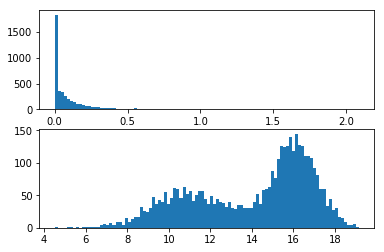

In [48]:
y_train_nolog = y_train
y_test_nolog = y_test
y_train = np.log1p(y_train_nolog)
y_test = np.log1p(y_test_nolog)

plt.subplot(2, 1, 1)
plt.hist(y_train_nolog, bins = 100)
plt.subplot(2, 1, 2)
plt.hist(y_train, bins = 100)
plt.show()

Visualization of budget

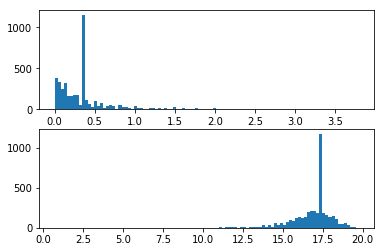

In [49]:
X_train['budget_log'] = np.log1p(X_train.budget)
X_test['budget_log'] = np.log1p(X_test.budget)

plt.subplot(2,1,1)
plt.hist(X_train.budget, bins = 100)
plt.subplot(2,1,2)
plt.hist(np.log1p(X_train.budget), bins = 100)
plt.show()

In [64]:
del X_train['budget']
del X_test['budget']

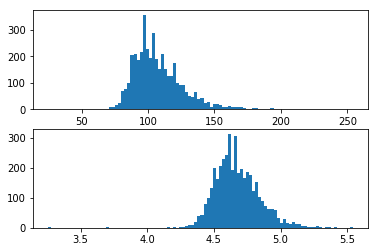

In [50]:
plt.subplot(2,1,1)
plt.hist(X_train.runtime, bins = 100)
plt.subplot(2,1,2)
plt.hist(np.log1p(X_train.runtime), bins = 100)
plt.show()

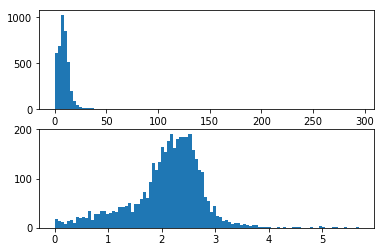

In [51]:
X_train['popularity_log'] = np.log1p(X_train.popularity)
X_test['popularity_log'] = np.log1p(X_test.popularity)

plt.subplot(2,1,1)
plt.hist(X_train.popularity, bins = 100)
plt.subplot(2,1,2)
plt.hist(X_train.popularity_log, bins = 100)
plt.show()

In [63]:
del X_train['popularity']
del X_test['popularity']

Overview

In [52]:
vectorizer = TfidfVectorizer(
            sublinear_tf=True,
            analyzer='word',
            token_pattern=r'\w{1,}',
            ngram_range=(1, 2),
            min_df=5)

overview_text = vectorizer.fit_transform(X_train['overview'].fillna(''))
linreg = LinearRegression()
linreg.fit(overview_text, y_train.fillna(0)) # looks better with y_train_nolog
eli5.show_weights(linreg, vec=vectorizer, top=20, feature_filter=lambda x: x != '<BIAS>')

In [53]:
random_film = np.random.randint(0,len(X_train))
print('Target value:', y_train[random_film])
eli5.show_prediction(linreg, doc=X_train['overview'].values[random_film], vec=vectorizer)

Target value: 14.229489321837644


Tagline

In [54]:
vectorizer_tagline = TfidfVectorizer(
                    sublinear_tf=True,
                    analyzer='word',
                    token_pattern=r'\w{1,}',
                    ngram_range=(1, 2),
                    min_df=5)

tagline_text = vectorizer_tagline.fit_transform(X_train['tagline'].fillna(''))
linreg_tagline = LinearRegression()
linreg_tagline.fit(tagline_text, y_train.fillna(0)) # looks better with y_train_nolog
eli5.show_weights(linreg_tagline, vec=vectorizer_tagline, top=20, feature_filter=lambda x: x != '<BIAS>')

In [55]:
random_film = np.random.randint(0,len(X_train))
print('Target value:', y_train[random_film])
eli5.show_prediction(linreg_tagline, doc=X_train['tagline'].values[random_film], vec=vectorizer_tagline)

Target value: 10.251288236449755


Release Date

In [56]:
X_test.loc[X_test['release_date'].isnull() == True, 'release_date'] = '01/01/98'

In [57]:
X_train['release_date']=X_train['release_date'].fillna("01/01/1998")

In [58]:
def fix_date(x):
    """
    Fixes dates which are in 20xx
    """
    temp=x.split('/')
    if int(temp[0])>12:
        year=temp[0]
        return x[5:] + '/'+ year
    else:
        year = x.split('/')[2]
        if int(year)<1900:
            if int(year) <= 19:
                return x[:-2] + '20' + year
            else:
                return x[:-2] + '19' + year
        else:
            return x

In [59]:
X_train['release_date'] = X_train['release_date'].apply(lambda x: fix_date(x))
X_test['release_date'] = X_test['release_date'].apply(lambda x: fix_date(x))
X_train['release_date'] = pd.to_datetime(X_train['release_date'])
X_test['release_date'] = pd.to_datetime(X_test['release_date'])

In [60]:
# creating features based on dates
def process_date(df):
    date_parts = ["year", "weekday", "month", 'weekofyear', 'day', 'quarter']
    for part in date_parts:
        part_col = 'release_date' + "_" + part
        df[part_col] = getattr(df['release_date'].dt, part).astype(int)
    
    return df

X_train = process_date(X_train)
X_test = process_date(X_test)

In [61]:
del X_train['release_date']
del X_train['tagline']
del X_train['overview']

del X_test['release_date']
del X_test['tagline']
del X_test['overview']

In [68]:
print(X_train.isnull().sum().sum())
print(X_test.isnull().sum().sum())

0
0


In [72]:
X_train.to_csv('X_train_final', index=False)
X_test.to_csv('X_test_final', index = False)

In [73]:
y_train.to_csv('y_train_final', index = False)
y_test.to_csv('y_test_final', index = False)